# Create and save average characteristic maps

## Open data

In [1]:
import os
import pickle
from datetime import datetime, date

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature

In [27]:
SAVE_FIGS = False

In [28]:
REPO_ROOT = os.getenv('REPO_ROOT', '/Users/rwegener/repos/chesapeake_mhw')

Open MHW event statistics

In [29]:
filepath = os.path.join(
    REPO_ROOT,
    'data/interim',
    'mhw_eventstats_dict.pickle',
)
with open(filepath, 'rb') as f:
    event_statistics = pickle.load(f)

Open geopolar SST

In [30]:
sst_filename = 'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20020901_20230831.nc'
path = os.path.join(REPO_ROOT, 'data/raw', sst_filename)
geopolar = xr.open_dataset(path)
geopolar = geopolar.analysed_sst

## Calculate Average Stats by pixel

Define functions for each of the MHW stats aggregations.

In [31]:
def no_occurrences(time_arr):
    '''
    returns the number of MHW events detected over the full time series
    '''
    return len(time_arr['time_start'])

In [32]:
def avg_duration(time_arr):
    '''
    returns the average duration of a MHW event over the full time series
    '''
    return np.mean(time_arr['duration'])

In [33]:
def avg_max_intensity(time_arr):
    '''
    returns the average value for the maximum intensity, `intensity_max`, 
    averaged over the full time series
    '''
    return np.mean(time_arr['intensity_max'])

In [34]:
def avg_mean_intensity(time_arr):
    '''
    returns the average value for the mean intensity, `intensity_mean`, 
    averaged over the full time series
    '''
    return np.mean(time_arr['intensity_mean'])

In [35]:
def avg_no_annual_events(time_arr):
    '''
    counts the number of mhw in each year and returns the average number
    over MHW events per year
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # count the number of events for every year from 2003 to 2021
    # don't include 2002 or 2022 because we don't have the full time series
    year_counts = np.empty(len(range(2003, 2022)))
    for i, yr in enumerate(range(2003, 2022)):
        year_counts[i] = np.count_nonzero(years == yr)
    
    # find the average number of events per year
    return np.mean(year_counts)

In [36]:
def avg_rate_onset(time_arr):
    '''
    returns the rate of onset of MHW, averaged over all MHW in the time 
    series (`rate_onset`)
    '''
    return np.mean(time_arr['rate_onset'])

In [37]:
def avg_rate_decline(time_arr):
    '''
    returns the rate of decline of MHW, averaged over all MHW in the time series 
    (`rate_decline`)
    '''
    return np.mean(time_arr['rate_decline'])

In [38]:
def avg_cum_intensity(time_arr):
    '''
    calculate the cumulative intensity in each year and returns the average over
    all the years
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # create a pandas dataframe to zip the years and the cumultive intensities
    df = pd.DataFrame({'year': years, 
                       'cumulative_intensity': time_arr['intensity_cumulative']})
    # groupby to take the mean of each year
    df = df.groupby('year').mean()
    # reindex to make sure that years without marine heatwaves are still present
    df = df.reindex(range(2003, 2022), fill_value=0)
    
    # find the average number of events per year
    return df['cumulative_intensity'].mean()

Run the functions on each of the pixels in the dataset

In [39]:
def apply_function(function, mhw_event_statistics, matching_arr):
    """
    Apply the given function in a vectorized manner (over all the pixels)
    to the MHW event data from mhw.detect(). Reformat and output as a
    dataarray.
    :function: a function which takes a 1D array that is to be applied to all
    the pixels
    :avg_stats_arr: the 0th output of the mhw.detect() function, in an array
    form for all of the pixels
    :matching_arr: a dataarray with lat and lon that has coordinate dimensions
    that matching the pixel locations of avg_stats_arr
    """
    stats_output = np.vectorize(function)(mhw_event_statistics)
    return xr.DataArray(stats_output, 
                          coords=[matching_arr.lat.values, 
                                  matching_arr.lon.values], 
                          dims=['latitude', 'longitude'])

In [40]:
no_occ_da = apply_function(no_occurrences, event_statistics, geopolar)
avg_dur_da = apply_function(avg_duration, event_statistics, geopolar)
avg_max_int_da = apply_function(avg_max_intensity, event_statistics, geopolar)
avg_mean_int_da = apply_function(avg_mean_intensity, event_statistics, geopolar)

avg_rate_on_da = apply_function(avg_rate_onset, event_statistics, geopolar)
avg_rate_off_da = apply_function(avg_rate_decline, event_statistics, geopolar)

avg_annual_events_da = apply_function(avg_no_annual_events, event_statistics, geopolar)
avg_cum_intensity_da = apply_function(avg_cum_intensity, event_statistics, geopolar)

/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in avg_duration (vectorized)
  outputs = ufunc(*inputs)
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in avg_max_intensity (vectorized)
  outputs = ufunc(*inputs)
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encoun

## Save each statistic into individual netcdf files

In [41]:
output_dir = './data/processed/mhw_stats_outputs/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Creating a land mask

In [42]:
mask = geopolar.isel(time=0).drop('time').rename(
    {'lat': 'latitude', 'lon': 'longitude'}
)

Number of Occurrences

In [43]:
# mask out land
no_occ_da = no_occ_da.where(~mask.isnull())

# Add metadata
no_occ_da = no_occ_da.rename('total_no_occurrences').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# of MHW', 'description': 
     "The total number of MHWs reported from EJO's MHW code for each pixel. " \
     "Passing along EJO's `n_events` metric.", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
no_occ_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'no_occurrences_CBay_geopolar.nc')
)

Average Duration

In [44]:
# Add metadata
avg_dur_da = avg_dur_da.rename('avg_duration').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# of days', 'description': "The 'duration' " \
     "statistic reported from EJO's MHW code for each pixel, averaged over all of " \
     "the MHW identified in that pixel", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')
    }
)

# Save
avg_dur_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_mhw_duration_CBay_geopolar.nc')
)

Average Max Intensity

In [45]:
# Add metadata
avg_max_int_da = avg_max_int_da.rename('avg_max_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C', 
     'description': "returns the average value for the maximum intensity, " \
     "`intensity_max`, averaged over the full time series", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_max_int_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_max_intensity_CBay_geopolar.nc')
)

Average Mean Intensity

In [46]:
# Add metadata
avg_mean_int_da = avg_mean_int_da.rename('avg_mean_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C', 
     'description': "returns the average value for the mean intensity, " \
     "`intensity_mean`, averaged over the full time series", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_mean_int_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_mean_intensity_CBay_geopolar.nc')
)

Average rate of onset

In [47]:
# Add metadata
avg_rate_on_da = avg_rate_on_da.rename('avg_onset_rate').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C / day', 'description': "returns " \
     "the rate of onset of MHW, averaged over all MHW in the time series " \
     "(`rate_onset`)", 'processing_date':  datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_rate_on_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_rate_onset_CBay_geopolar.nc')
)

Average rate of decline

In [48]:
# Add metadata
avg_rate_off_da = avg_rate_off_da.rename('avg_decline_rate').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C / day', 'description': "returns " \
    "the rate of deline of MHW, averaged over all MHW in the time series " \
    "(`rate_decline`)", 'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_rate_off_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_rate_decline_CBay_geopolar.nc')
)

Average number of annual events

In [49]:
# Mask land
avg_annual_events_da = avg_annual_events_da.where(~mask.isnull())

# Add metadata
avg_annual_events_da = avg_annual_events_da.rename('avg_no_annual_events').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# MHW', 'description': "counts the number " \
     "of mhw in each year and returns the average number of MHW events per year", 
     'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_annual_events_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_no_annual_events_CBay_geopolar.nc')
)

Average cumulative intensity

In [50]:
# Mask land
avg_cum_intensity_da = avg_cum_intensity_da.where(~mask.isnull())

# Add metadata
avg_cum_intensity_da = avg_cum_intensity_da.rename('avg_cum_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C * day', 'description': "calculate the " \
     "cumulative intensity of all the mhw for each year and returns the average over " \
     "all the years", 'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_cum_intensity_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_cum_intensity_CBay_geopolar.nc')
)

## Making full plot

### A Big Group Photo

Plotting all the characteristics together

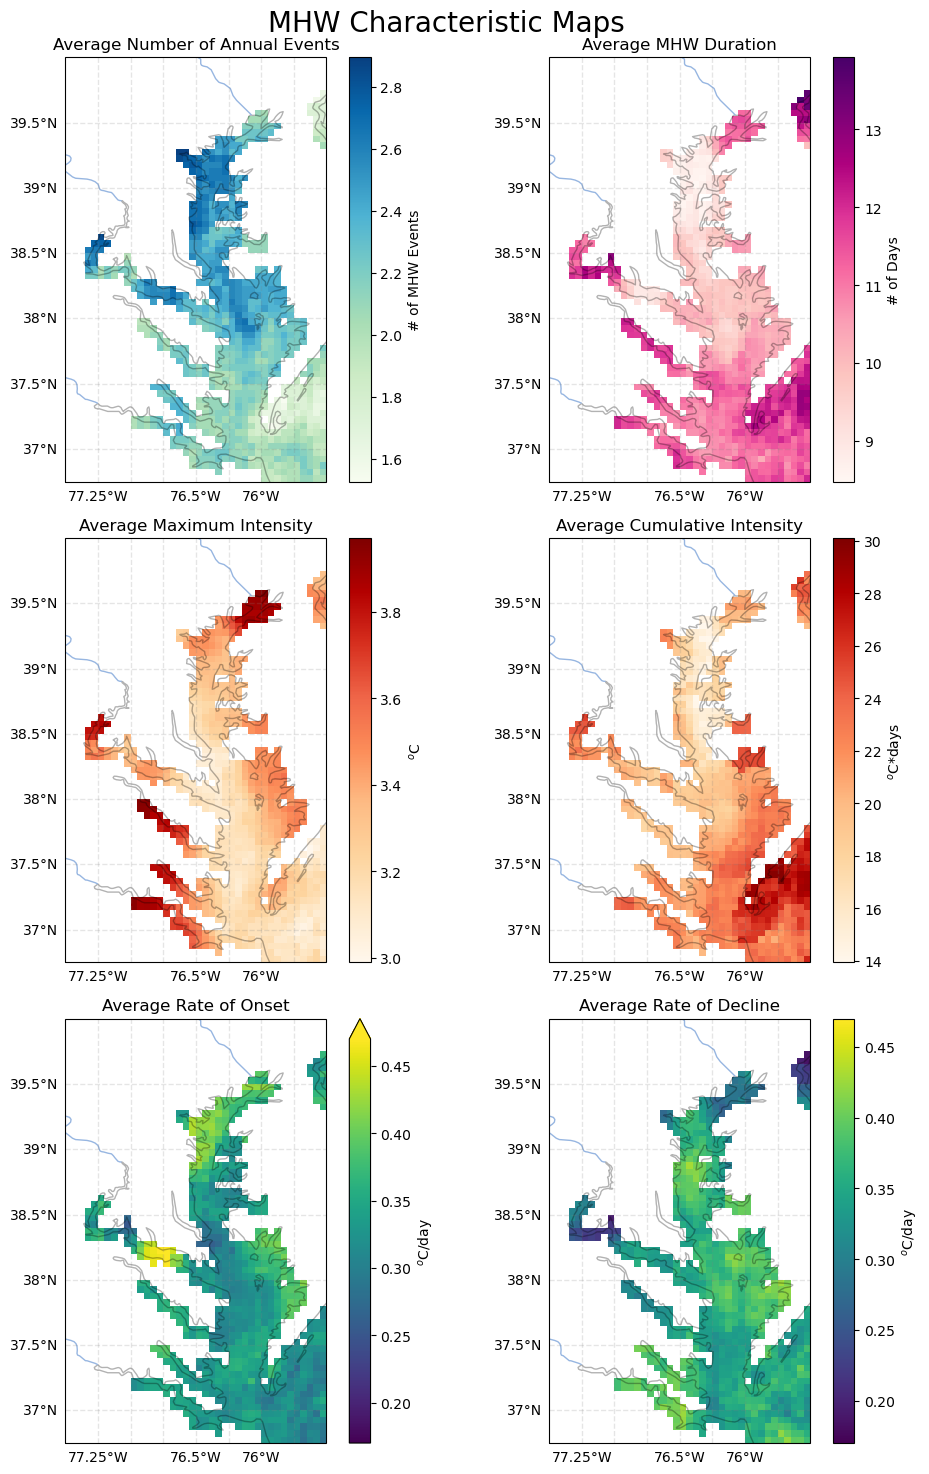

In [51]:
fig, axes = plt.subplots(3, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(10, 15)
fig.suptitle('MHW Characteristic Maps', size=20)

# Add background features
for ax in axes.flatten():
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# no. of annual events and duration
cbar_unit = '# of MHW Events'
avg_annual_events_da.plot(ax=axes[0, 0], cmap='GnBu', cbar_kwargs={'label': cbar_unit},)
axes[0, 0].set_title('Average Number of Annual Events')
cbar_unit = '# of Days'
avg_dur_da.plot(ax=axes[0, 1], cmap='RdPu', cbar_kwargs={'label': cbar_unit},)
axes[0, 1].set_title('Average MHW Duration')

# Average maximum intensity and cumulative intensity
cbar_unit = '$^o$C'
avg_max_int_da.plot(ax=axes[1, 0], cmap='OrRd', cbar_kwargs={'label': cbar_unit},)
axes[1, 0].set_title('Average Maximum Intensity')
cbar_unit = '$^o$C*days'
avg_cum_intensity_da.plot(ax=axes[1, 1], cmap='OrRd', cbar_kwargs={'label': cbar_unit},)
axes[1, 1].set_title('Average Cumulative Intensity')

# rate of onset and rate of decline
cbar_unit = '$^o$C/day'
vmin, vmax = 0.17, 0.47
avg_rate_on_da.plot(ax=axes[2, 0], cbar_kwargs={'label': cbar_unit}, vmin=vmin, vmax=vmax)
axes[2, 0].set_title('Average Rate of Onset')
cbar_unit = '$^o$C/day'
avg_rate_off_da.plot(ax=axes[2, 1], cbar_kwargs={'label': cbar_unit}, vmin=vmin, vmax=vmax)
axes[2, 1].set_title('Average Rate of Decline')

fig.tight_layout()

if SAVE_FIGS:
    plt.savefig('../figures/mhw_maps/all_characteristics.png', dpi=400, 
                bbox_inches='tight')


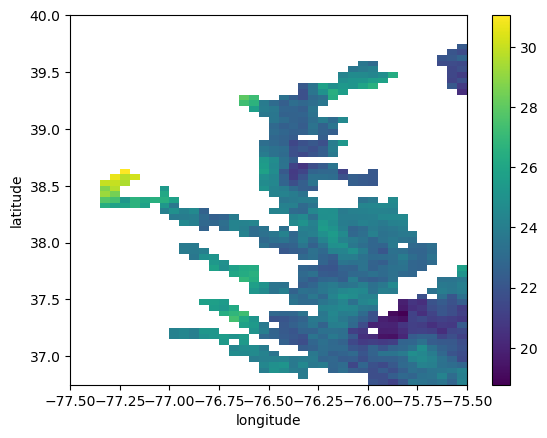

In [66]:
(avg_annual_events_da * avg_dur_da).plot()

In [71]:
SAVE_FIGS = True

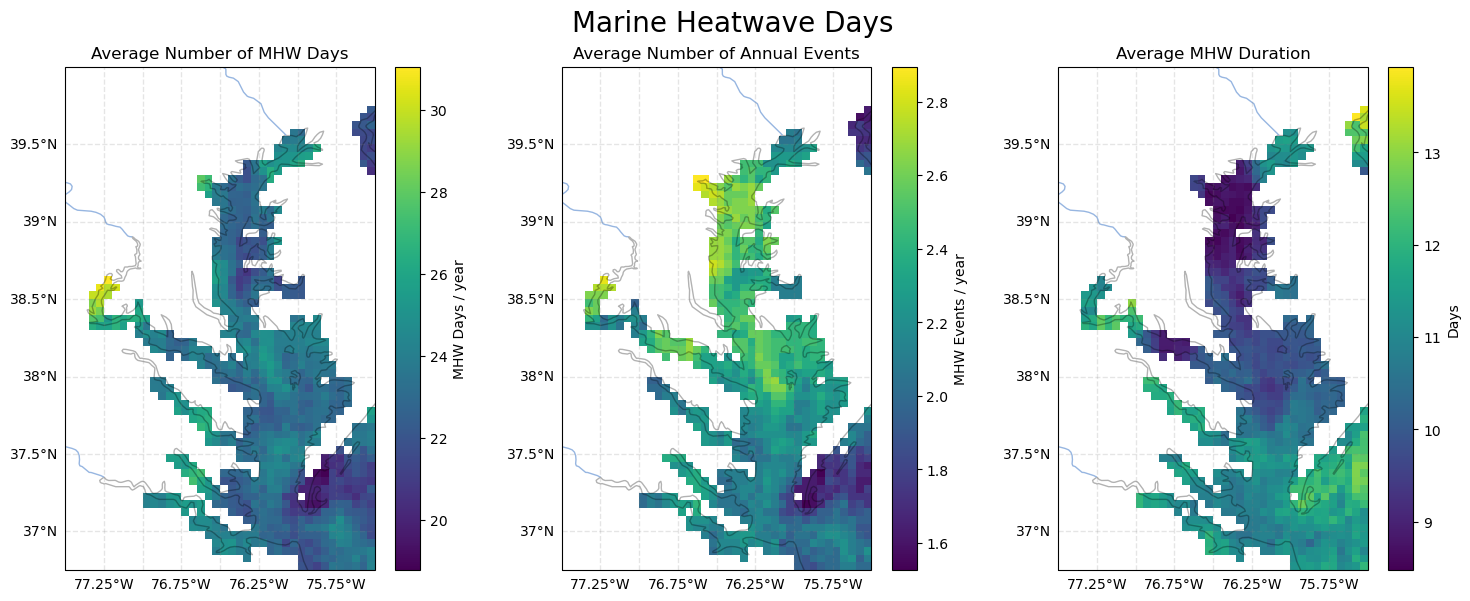

In [72]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(15, 6)
fig.suptitle('Marine Heatwave Days', size=20)

# Add background features
for ax in axes.flatten():
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# no. of annual events and duration
cbar_unit = 'MHW Days / year'
(avg_annual_events_da * avg_dur_da).plot(ax=axes[0], cbar_kwargs={'label': cbar_unit})
axes[0].set_title('Average Number of MHW Days')

cbar_unit = 'MHW Events / year'
avg_annual_events_da.plot(ax=axes[1], cbar_kwargs={'label': cbar_unit},)
axes[1].set_title('Average Number of Annual Events')

cbar_unit = 'Days'
avg_dur_da.plot(ax=axes[2], cbar_kwargs={'label': cbar_unit},)
axes[2].set_title('Average MHW Duration')

# Average maximum intensity and cumulative intensity


fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT,'figures/mhw_maps', 'average_mhw_days.png'), 
                dpi=400, 
                bbox_inches='tight'
               )


### A Smaller Group Photo

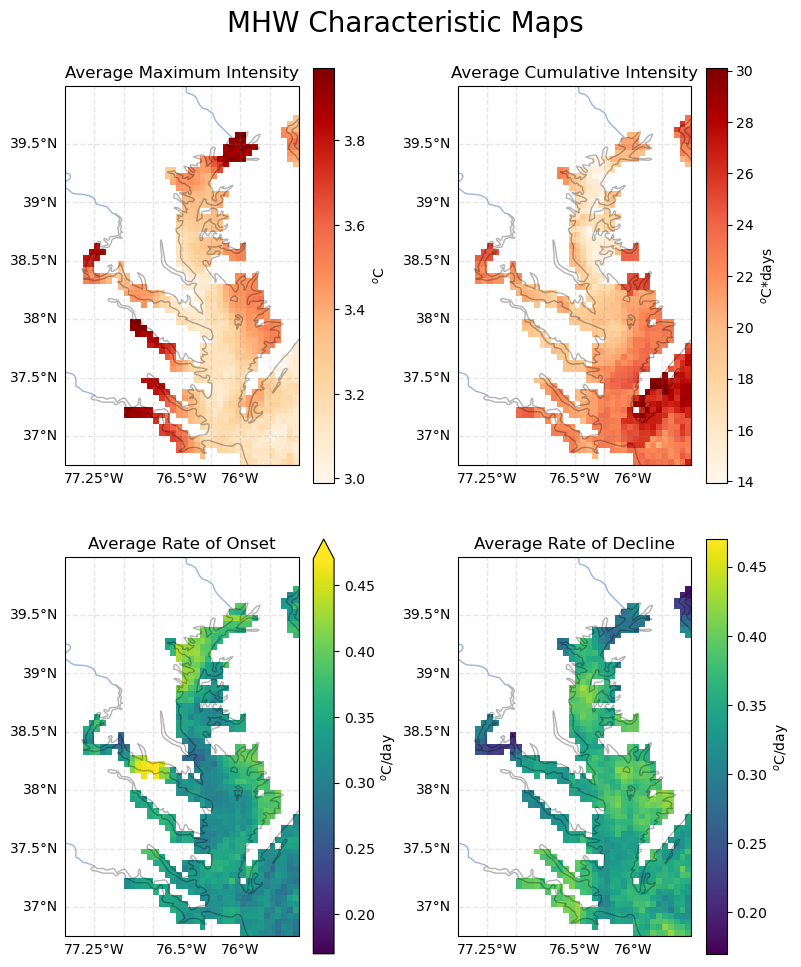

In [52]:
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(8, 10)
fig.suptitle('MHW Characteristic Maps', size=20)

# Add background features
for ax in axes.flatten():
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# # no. of annual events and duration
# cbar_unit = '# of MHW Events'
# avg_annual_events_da.plot(ax=axes[0, 0], cmap='GnBu', cbar_kwargs={'label': cbar_unit},)
# axes[0, 0].set_title('Average Number of Annual Events')
# cbar_unit = '# of Days'
# avg_dur_da.plot(ax=axes[0, 1], cmap='RdPu', cbar_kwargs={'label': cbar_unit},)
# axes[0, 1].set_title('Average MHW Duration')

# Average maximum intensity and cumulative intensity
cbar_unit = '$^o$C'
avg_max_int_da.plot(ax=axes[0, 0], cmap='OrRd', cbar_kwargs={'label': cbar_unit},)
axes[0, 0].set_title('Average Maximum Intensity')
cbar_unit = '$^o$C*days'
avg_cum_intensity_da.plot(ax=axes[0, 1], cmap='OrRd', cbar_kwargs={'label': cbar_unit},)
axes[0, 1].set_title('Average Cumulative Intensity')

# rate of onset and rate of decline
cbar_unit = '$^o$C/day'
vmin, vmax = 0.17, 0.47
avg_rate_on_da.plot(ax=axes[1, 0], cbar_kwargs={'label': cbar_unit}, vmin=vmin, vmax=vmax)
axes[1, 0].set_title('Average Rate of Onset')
cbar_unit = '$^o$C/day'
avg_rate_off_da.plot(ax=axes[1, 1], cbar_kwargs={'label': cbar_unit}, vmin=vmin, vmax=vmax)
axes[1, 1].set_title('Average Rate of Decline')

fig.tight_layout()

if SAVE_FIGS:
    plt.savefig('../figures/mhw_maps/all_characteristics.png', dpi=400, 
                bbox_inches='tight')
